# Taxi Trajectory Prediction
## Graham Daley
## DS5, 2015

## 2) Data Aquisition and Visualisation

In [1]:
import pandas as pd

train_data = pd.read_csv("../data/project/train.csv")

In [2]:
train_data = train_data[train_data['MISSING_DATA'] == False]
train_data['POINTS'] = map(lambda polyline: polyline.count("]") - 1, train_data['POLYLINE'])
train_data = train_data[train_data['POLYLINE'] > 0]
train_data.head(3)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,POINTS
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",23
1,1372637303620000596,B,NaN,7,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",19
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",65


In [5]:
import datetime
print datetime.datetime.fromtimestamp(train_data.loc[0, "TIMESTAMP"]).strftime('%Y-%m-%d %H:%M:%S')

2013-07-01 00:00:58


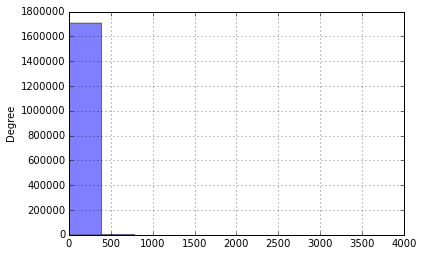

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
train_data["POINTS"].plot(kind='hist', alpha=0.5)

In [3]:
train_data.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POINTS
count,1.710660e+06,364769.000000,806576.000000,1710660.000000,1.710660e+06,1710660,1710660.000000
mean,-1.281841e+11,24490.403461,30.272320,20000348.530263,1.388622e+09,0,48.758033
std,9.180948e+15,19624.301741,17.747814,211.240149,9.180948e+06,0,45.652243
min,1.372637e+18,2001.000000,1.000000,20000001.000000,1.372637e+09,False,0.000000
25%,1.380731e+18,6593.000000,15.000000,20000166.000000,1.380731e+09,0,28.000000
50%,1.388493e+18,18755.000000,27.000000,20000345.000000,1.388493e+09,0,41.000000
75%,1.396750e+18,40808.000000,49.000000,20000520.000000,1.396750e+09,0,59.000000
max,1.404173e+18,63884.000000,63.000000,20000981.000000,1.404173e+09,False,3881.000000


In [4]:
train_data[train_data["POINTS"] == 1].count()

TRIP_ID         30607
CALL_TYPE       30607
ORIGIN_CALL      1628
ORIGIN_STAND     7087
TAXI_ID         30607
TIMESTAMP       30607
DAY_TYPE        30607
MISSING_DATA    30607
POLYLINE        30607
POINTS          30607
dtype: int64

In [5]:
train_data.CALL_TYPE.value_counts()

B    817878
C    528013
A    364769
dtype: int64

In [6]:
train_data.DAY_TYPE.value_counts()

A    1710660
dtype: int64

In [8]:
import pandas as pd

test_data = pd.read_csv("../data/project/test.csv")
test_data['POINTS'] = map(lambda polyline: polyline.count("]") - 1, test_data["POLYLINE"])
test_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,POINTS
0,T1,B,NaN,15,20000542,1408039037,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...",11
1,T2,B,NaN,57,20000108,1408038611,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...",40
2,T3,B,NaN,15,20000370,1408038568,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...",40
3,T4,B,NaN,53,20000492,1408039090,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...",8
4,T5,B,NaN,18,20000621,1408039177,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]",2


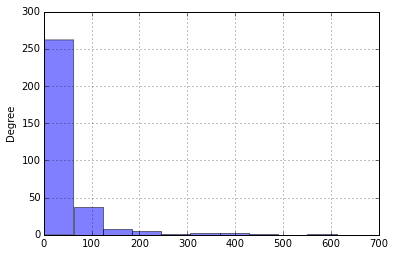

In [36]:
plt.figure()
test_data["POINTS"].plot(kind='hist', alpha=0.5)

In [8]:
test_data.describe()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POINTS
count,72.000000,123.000000,320.000000,3.200000e+02,320,320.000000
mean,38074.083333,29.991870,20000353.587500,1.412465e+09,0,45.118750
std,28528.026167,18.444198,206.535355,3.144882e+06,0,66.739927
min,2002.000000,1.000000,20000004.000000,1.408032e+09,False,1.000000
25%,9159.500000,15.000000,20000175.500000,1.412064e+09,0,14.000000
50%,36879.500000,23.000000,20000351.500000,1.412616e+09,0,26.500000
75%,65548.250000,49.000000,20000517.250000,1.414814e+09,0,48.000000
max,86436.000000,63.000000,20000904.000000,1.419172e+09,False,612.000000


In [22]:
test_data.CALL_TYPE.value_counts()

C    125
B    123
A     72
dtype: int64

In [9]:
test_data.DAY_TYPE.value_counts()

A    320
dtype: int64

## Initial thoughts

Having looked at the overall structure of the training and test data, the following points come to mind initially:

* The DAY_TYPE column is always 'A', in both training and testing data sets, so it can be removed.

* The polyline point coordinates should be separated into individual features, however the trips do not all have an identical number of points specified.

* The number of polyline points for the trips in the training data ranges from 0 to 3,881. Test data points range from 1 to 612. It might make sense to limit the number of points used in the model when training.

* The duration of the (partial) journey could be estimated by the number of points x 15 seconds.

* In the training data, there are some special cases:

    * 30,607 trips with only 1 point. Did these trips take less than 30 seconds? The test data includes one such trip.
    
    * 5,901 trips with no points. Extremely short trips, less than 15 seconds? The test data does not include any trips with no points, so I assume these can be removed?

* Call type 'A' has some additional information associated with it – a unique identifier of the caller. It might be worthwhile having a separate model for these calls, which takes this into consideration.

In [12]:
import json
import folium
from IPython.display import HTML
from random import randint

def display(m, height=1000):
    """Takes a folium instance and embeds in HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{0}" '
                 'style="width: 100%; height: {1}px; '
                 'border: none"></iframe>'.format(srcdoc, height))
    return embed

map_osm = folium.Map(location=[41.1579438, -8.629105299999992],
                    zoom_start=13)
for t in range(3):
    trip = randint(0, 1710659)
    polyline = json.loads(train_data.loc[trip, "POLYLINE"])
    for i, pt in enumerate(polyline):
        if i == 0:
            # Starting point in green
            lcolor = '#00FF00'
            fcolor = '#11FF11'
            radius = 100
        elif i == len(polyline) - 1:
            # End point in red
            lcolor = '#FF0000'
            fcolor = '#FF1111'
            radius = 100
        else:
            lcolor = '#000000'
            fcolor = '#000000'
            radius = 30
        map_osm.circle_marker(location=[pt[1], pt[0]], radius=radius,
                              line_color=lcolor,
                              fill_color=fcolor, fill_opacity=0.5)

map_osm.create_map(path='osm.html')
display(map_osm, height=500)

## 2) Reformatting the Data

In [35]:
import csv
import json

DATA_DIR = "../data/project"

def transform_dataset(filename, is_test=False):
    """
    Transform the given dataset to create features for some of the points
    in the poly line.
    """
    in_filename = "{0}/{1}.csv".format(DATA_DIR, filename)
    out_filename = "{0}/{1}_transformed.csv".format(DATA_DIR, filename)
    field_names = ["CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID",
                   "POINTS", "LON1", "LAT1", "LON2", "LAT2", "LONF", "LATF"]
    if is_test:
        field_names.remove("LONF")
        field_names.remove("LATF")

    with open(out_filename, "wb") as out_file:
        csv_writer = csv.DictWriter(out_file, fieldnames=field_names)
        csv_writer.writeheader()
        with open(in_filename) as in_file:
            csv_reader = csv.DictReader(in_file)
            
            for line in csv_reader:
                if line["MISSING_DATA"] == "False":
                    polyline = json.loads(line["POLYLINE"])
                    if len(polyline) > 0:
                        try:
                            line["LON1"] = polyline[0][0]
                            line["LAT1"] = polyline[0][1]
                        except:
                            line["LON1"] = -999
                            line["LAT1"] = -999
                        try:
                            line["LON2"] = polyline[-2][0]
                            line["LAT2"] = polyline[-2][1]
                        except:
                            line["LON2"] = -999
                            line["LAT2"] = -999
                        if is_test == False:
                            try:
                                line["LONF"] = polyline[-1][0]
                                line["LATF"] = polyline[-1][1]
                            except:
                                line["LONF"] = -999
                                line["LATF"] = -999
                            
                        line["POINTS"] = len(polyline)
                        del line["POLYLINE"]
                        del line["DAY_TYPE"]
                        del line["TRIP_ID"]
                        del line["TIMESTAMP"]
                        del line["MISSING_DATA"]
                        csv_writer.writerow(line)
                
transform_dataset("train")
transform_dataset("test", is_test=True)

In [36]:
import pandas as pd

DATA_DIR = "../data/project"

train = pd.read_csv("{0}/{1}".format(DATA_DIR, "train_transformed.csv"))

# Not going to use these for now, so drop them
#train.drop('CALL_TYPE', axis=1, inplace=True)
#train.drop('ORIGIN_CALL', axis=1, inplace=True)
#train.drop('ORIGIN_STAND', axis=1, inplace=True)
train["CALL_TYPE"] = pd.factorize(train["CALL_TYPE"])[0]
train = train.fillna(-1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704759 entries, 0 to 1704758
Data columns (total 11 columns):
CALL_TYPE       int64
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID         int64
POINTS          int64
LON1            float64
LAT1            float64
LON2            float64
LAT2            float64
LONF            float64
LATF            float64
dtypes: float64(8), int64(3)
memory usage: 156.1 MB


In [37]:
import pandas as pd

test = pd.read_csv("../data/project/test_transformed.csv")

# Not going to use these for now, so drop them
#test.drop('CALL_TYPE', axis=1, inplace=True)
#test.drop('ORIGIN_CALL', axis=1, inplace=True)
#test.drop('ORIGIN_STAND', axis=1, inplace=True)

test["CALL_TYPE"] = pd.factorize(test["CALL_TYPE"])[0]
test = test.fillna(-1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns (total 9 columns):
CALL_TYPE       320 non-null int64
ORIGIN_CALL     320 non-null float64
ORIGIN_STAND    320 non-null float64
TAXI_ID         320 non-null int64
POINTS          320 non-null int64
LON1            320 non-null float64
LAT1            320 non-null float64
LON2            320 non-null float64
LAT2            320 non-null float64
dtypes: float64(6), int64(3)
memory usage: 25.0 KB


In [38]:
import numpy as np
import pandas as pd

# Generate Labels and drop them from training set
labels = np.array(train[['LATF', 'LONF']])
train = train.drop(['LATF', 'LONF'], axis = 1)
train = np.array(train)
test = np.array(test)

train = train.astype(float)
test = test.astype(float)

In [39]:
from sklearn import ensemble

# Initialize the famous Random Forest Regressor from scikit-learn
clf = ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=100)
#clf = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=100)
clf.fit(train, labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [40]:
# Write predictions to file
preds = clf.predict(test)
sample = pd.read_csv("../data/project/sampleSubmission.csv")
sample['LATITUDE'] = preds[:,1]
sample['LONGITUDE'] = preds[:,0]
sample.to_csv('../data/project/benchmark.csv', index=False)
print "Score:", clf.score(train, labels)

Score: 0.931985226975


However, this score only translates into an accuracy of 7,500 on Kaggle, so I must be doing something badly wrong here!